<a href="https://colab.research.google.com/github/lauraciurca/A-ML-Approach-for-Detecting-Brute-Force-Attacks/blob/main/FEATURE_EXTRACTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATA PRE-PROCESSING**

**Libraries**

In [1]:
from google.colab import drive
import glob
import pandas as pd 
from ast import literal_eval
import numpy as np
from datetime import datetime
from itertools import groupby
from datetime import datetime
import statistics
from scipy.stats import skew
from scipy.stats import norm, kurtosis
from statsmodels.tsa.stattools import adfuller
import itertools
import matplotlib.pyplot as plt 
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pandas import Series, DataFrame
from sklearn.model_selection import GridSearchCV
import random
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from scipy.stats import kurtosis
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.ensemble import IsolationForest

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Importing Data**

In [2]:
#connect to drive to access data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#get all files from drive 
def import_data(path):
  logfiles = glob.glob(path)
  logfil=[]
  for i in logfiles:
    f  = open(i, "r")
    data=pd.DataFrame(f)
    logfil.append(data)
  df = pd.concat(logfil)
  df=df.reset_index(drop=True)
  return df

In [4]:
attacks= import_data("/content/drive/MyDrive/LOG/Log_files/*") 
normal= import_data("/content/drive/MyDrive/LOG/Log_files_normali/*") 

In [5]:
len(attacks), len(normal)

(538810, 109)

In [5]:
#check data entry
attacks[0].values[4]

'{"host.hostname":"xecvmlab02","user.name":"xec_admin","host":"xecvmlab02","@timestamp":"2021-09-01T14:18:02.594Z","source.ip":"172.18.0.25","@version":"1","path":"/var/log/secure","process.pid":"18954","system.auth.ssh.event":"Failed","source.port":"45916","message":"Sep  1 16:18:01 xecvmlab02 sshd[18954]: Failed password for xec_admin from 172.18.0.25 port 45916 ssh2","process.name":"sshd","system.auth.ssh.method":"password","system.auth.timestamp":"Sep  1 16:18:01"}\n'

**Dataframe Creation**

In [6]:
#dictionary function
def dicto(x,df):
  k=literal_eval(df[0][x]) 
  return k

In [7]:
#dataframe creation after dictionary creation
def transform_data(data):
  zxx=[]
  for i in range(len(data)):
    zxx.append(dicto(i,data))
  ds= [d for d in zxx if 'system.auth.ssh.event' in d]
  super_dict= {}
  for d in ds:
    for k, v in d.items():  
       super_dict.setdefault(k, []).append(v)
  data= pd.DataFrame([super_dict['@timestamp'],super_dict['system.auth.ssh.event']])
  data_t=data.T
  return data_t

In [8]:
attacks= transform_data(attacks)
normal= transform_data(normal)

In [9]:
#removing rows that are errors or invalid
def remove_noise(dataset):
  dataset= dataset.drop(dataset[dataset[1].str.contains('Invalid')].index.tolist())
  dataset= dataset.drop(dataset[dataset[1].str.contains('error')].index.tolist())
  dataset= dataset.reset_index(drop=True)
  return dataset

In [10]:
attacks= remove_noise(attacks)
normal= remove_noise(normal)

In [11]:
#converting time into millisenconds
def get_millisecond(dataset):
  dataset[0]= dataset[0].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%f%z'))
  dataset[0]= dataset[0].apply(lambda x: x.timestamp() * 1000)
  dataset[0]= dataset[0].astype('int64') 
  return dataset

In [12]:
attacks= get_millisecond(attacks)
normal= get_millisecond(normal)

In [13]:
#rename columns
attacks= attacks.rename(columns={0: "time", 1: "event"})
normal= normal.rename(columns={0: "time", 1: "event"})

In [14]:
#attacks.head()
#normal.head()

Define each single access/attack session to the client; each row will represent an attack/login

In [14]:
def define_session(dataset):
  m= dataset.T
  columns= list(m) 
  result=[]
  start=True
  for i in columns:
    if start and m[i][1] == "Failed":
      result.append([m[i]])
      start = False
    elif m[i][1]=="Failed":
      result[-1].append(m[i])
    else:
      start = True 
  p = len(result)-1
  for lists in range(0,p):
    z = result[lists][-1].name 
    result[lists].append(m[z+1])
  dataset = pd.Series(result)
  dataset= dataset.to_frame()
  return dataset

In [15]:
attacks = define_session(attacks)
attacks = attacks.rename(columns={0: "data"})

In [16]:
normal = define_session(normal)
normal = normal.rename(columns={0: "data"})

Feature Extraction

In [17]:
#function to extract the count of fails and accepted
def failures_accepted(dataset):
  lists= []
  lists2= []
  for key, value in dataset.iteritems():
    for i in range(0,len(dataset)):
      s = value[i]
      s = str(s)
      z=s.count("Failed")
      z2=s.count("Accepted")
      lists.append(z)
      lists2.append(z2)
  dataset["fails"]=lists
  dataset["accepted"]=lists2

In [18]:
#failures_accepted(normal)
failures_accepted(attacks)
failures_accepted(normal)

In [19]:
#extract the interval of the attack in milliseconds
def interval(dataset):
  result=[]
  for l in dataset["data"]:
    mim=[]
    for j in range(len(l)):
      x = l[j][0]
      mim.append(x)
    result.append(mim)
  dataset["interval"] = result

In [20]:
#interval(normal)
interval(attacks)

In [21]:
interval(normal)

In [22]:
def plot_all_timeseries(data):
  for x in data:
    z=plt.figure()
    ax=z.add_subplot(111)    
    plt.plot(x)
    plt.show()

In [23]:
#extract the interval of the attack in milliseconds
def interval_fails(dataset):
  result=[]
  for l in dataset["data"]:
    mim=[]
    for j in range(len(l)-1):
      x = l[j][0]
      mim.append(x)
    result.append(mim)
  dataset["interval_fails"] = result

In [24]:
#interval_fails(normal)
interval_fails(attacks)

In [25]:
interval_fails(normal)

In [26]:
#define the attack/login duration
def attack_duration(dataset):
  diff=[]
  for f in dataset['interval']:
    x= f[-1]-f[0]
    diff.append(x)
  dataset["durata_attacco"] = diff

In [27]:
#attack_duration(normal)
attack_duration(attacks)

In [28]:
attack_duration(normal)

Divisione attacco nelle varie sottoparti

In [29]:
#define the average intercurring between a fail and another
def meani(mylist):
 l=[]
 for i in range(0,1):
    for j in range(i + 1, len(mylist)):
        z= mylist[j] - mylist[j-1]  
        l.append(z)
        medialista2= statistics.mean(l)
 return medialista2

In [30]:
def mean_attacks(dataset): 
  meansi2=[]
  for f in range(len(dataset)):
    single=dataset["data"][f]
    fails=[]
    for x in single:
        fail=x[1]
        if fail=="Failed":
          fails.append(x[0])
    mean_failures= meani(fails)
    meansi2.append(mean_failures)
  dataset["durata_media_tra_un_fail_e_l_altro"] = meansi2

In [31]:
mean_attacks(attacks)

In [32]:
pairs_result=[]
for l in attacks["interval_fails"]:
  pairs = []
  for first, second in zip(l, l[1:]):
    m = (first, second)
    pairs.append(m)
  pairs_result.append(pairs)

In [33]:
def separation(pairs,avg):
  new_list=[]
  start=True
  for t in range(len(pairs)):
   if start and abs(pairs[t][0] - pairs[t][1]) < avg: 
    new_list.append([(pairs[t][0],pairs[t][1])])
    start = False
   elif abs(pairs[t][0] - pairs[t][1]) < avg:
    new_list[-1].append((pairs[t][0],pairs[t][1]))
   else:
    start = True
  return new_list

In [34]:
all=[]
for f in range(len(pairs_result)):
  pairs = pairs_result[f]
  average= attacks["durata_media_tra_un_fail_e_l_altro"][f]
  f= separation(pairs,average)
  all.append(f)

In [35]:
final_result=[]
for c in range(0,len(all)):
 mmm = all[c]
 risult=[]
 for x in range(0,len(mmm)):
  j= mmm[x]
  res=[]
  if len(j) > 1:
    for item in j[0]:
      res.append(item)
    for t in range(1,len(j)):
      last = j[t][1]
      res.append(last)
  if len(j) == 1:         
   for t in j:
    for item in t:
      res.append(item)
  risult.append(res)
 final_result.append(risult)

In [36]:
attacks["divided_attack"] = final_result

In [37]:
session_fails=[]
for x in range(len(attacks["divided_attack"])):
    one = attacks["divided_attack"][x]
    lung=[]
    for y in range(len(one)):
      length=len(one[y])
      lung.append(length)
    session_fails.append(lung) 

In [ ]:
attacks["divided_attack"]

In [38]:
attacks["session_fails"]=session_fails

In [ ]:
faills=[]
for x in range(len(attacks["divided_attack"])):
  two = attacks["divided_attack"][x]
  ind=[]
  for y in range(len(two)):
    time= attacks["divided_attack"][x][y][0]
    failures=len(two[y])
    z=[time,failures]
    ind.append(z)
  faills.append(ind)

In [ ]:
timess=[]
for f in faills:
  data_single_attack = pd.DataFrame(f, columns =['time', 'action'])
  data_single_attack['time'] = pd.to_datetime(data_single_attack['time'], unit='ms')
  ts = data_single_attack.set_index('time')
  timess.append(ts)

In [635]:
c = timess[0]
c= group_timeseries(c)
len(c)

197

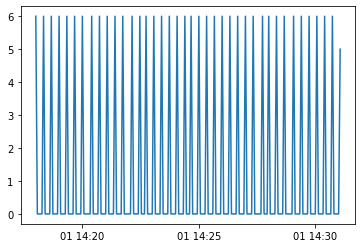

In [ ]:
plt.plot(c)

In [39]:
#standard deviation
def standard_dev(dataset):
  std=[]
  for f in dataset['session_fails']:
    if len(f)>2:
      x = statistics.stdev(f)
   #  x = format(x, 'f')
      std.append(x)
    else:
      std.append(0)
  dataset["standard_deviation"] = std

In [40]:
standard_dev(attacks)

In [41]:
#skewness
def skewness(dataset):
  skw=[]
  for f in dataset['session_fails']:
    x = skew(f)
 #   x = format(x, 'f')
    skw.append(x)
  dataset["skewness"] = skw

In [42]:
skewness(attacks)

In [43]:
#kurtosis
def kurtos(dataset):
  kurt=[]
  for f in dataset['session_fails']:
    x = kurtosis(f)
  #  x = format(x, 'f')
    kurt.append(x)
  dataset["kurtosis"] = kurt

In [44]:
kurtos(attacks)

In [45]:
def mean_vecchia(dataset):
  mean2=[]
  for f in dataset['session_fails']:
    if len(f)>1:
      x = statistics.mean(f)
    #x = format(x, 'f')
      mean2.append(x)
    else:
      mean2.append(0)
  dataset["durata_media_attacco2"] = mean2

In [46]:
mean_vecchia(attacks)

In [ ]:
#len(attacks)

82

normali

In [49]:
#define single timeseries
def timeseriess(data):
  for j in range(len(data)):
    if data[j][1]=="Failed":
      data[j][1]=1
    elif data[j][1]=="Accepted":
      data[j][1]=1
  single_att=[]
  for j in range(len(data)):
    data_action=[data[j][0],data[j][1]]
    single_att.append(data_action)
  data_data = pd.DataFrame(single_att, columns =['time', 'action'])
  data_data['time'] = pd.to_datetime(data_data['time'], unit='ms')
  ts = data_data.set_index('time')
  return ts

In [107]:
def group_timeseries(timeseries):
  grouped=timeseries.groupby(pd.Grouper(freq='4s')).agg({    
                                        "action": "sum"})
  return grouped

In [108]:
#define all timeseries for normal sessions
all_normals=[]
for i in range(len(normal)):
  single_session= normal["data"][i]
  ts= timeseriess(single_session)
  f= group_timeseries(ts)
  all_normals.append(f)

In [109]:
def reconvert_millisecond(dataset):
  dataset["time"]= pd.to_datetime(dataset['time']).dt.strftime("%Y-%m-%dT%H:%M:%S")
  dataset["time"]= dataset["time"].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%S'))
  dataset["time"]= dataset["time"].apply(lambda x: x.timestamp() * 1000)
  dataset["time"]= dataset["time"].astype('int64') 
  return dataset

In [110]:
data=[]
for x in range(len(all_normals)):
  m= all_normals[x]
  n = m.rename_axis('time').reset_index()
  reconvert_millisecond(n)
  fails=[]
  for x in range(len(n)):
    z= n["time"][x]
    y= n["action"][x]
    fails.append([z, y])
  data.append(fails)

In [111]:
normal["grouped_data"]=data

In [112]:
total_fail=[]
for x in normal["grouped_data"]:
  x=x[:-1]
  fails=[]
  for y in x:
    f=y[1]
    fails.append(f)
  total_fail.append(fails)

In [113]:
normal["session_fails"]=total_fail

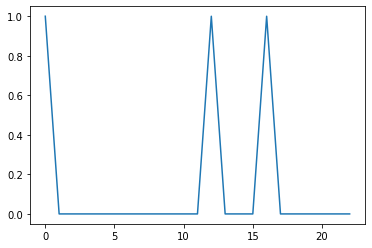

In [ ]:
#plot normal
plt.plot(normal["session_fails"][2])

In [114]:
mean_vecchia(normal)

In [115]:
standard_dev(normal)

In [116]:
standard_dev(normal)

In [117]:
kurtos(normal)

In [118]:
skewness(normal)

In [ ]:
attacks.to_csv("attacks.csv")
normal.to_csv("normal.csv")